## Objective: Hotel Booking Prediction
A hotel booking site wants to improve the booking experience from the users. 

Goal: Build models to predict whether a user will bok a hotel upon visiting the website, and which type of user most likely book a room

In [2]:
# Load built-in libraries
import requests
import pickle
import joblib

# Load data manipulation library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Load model libraries 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score

# Set model SEED for consistent results
SEED = 123

## Get Data

In [3]:
# Load data into Pandas DataFrame
df = pd.read_csv('hotel_booking.csv')
df.info()

Info of Booking data....

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_id    3000 non-null   int64  
 1   session_date   3000 non-null   object 
 2   age            1714 non-null   float64
 3   destination    3000 non-null   object 
 4   first_browser  3000 non-null   object 
 5   language       3000 non-null   object 
 6   booking        3000 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 164.2+ KB


In [4]:
df.head()

,customer_id,session_date,age,destination,first_browser,language,booking
0,1,2021-03-16 10:43:46,NaN,NDF,IE,en,1
1,2,2021-11-12 02:12:40,28.0,NDF,Chrome,en,1
2,3,2021-01-11 20:49:15,NaN,GB,-unknown-,en,1
3,4,2021-03-29 08:54:20,32.0,NDF,Safari,en,1
4,5,2021-10-05 15:45:37,NaN,NDF,IE,en,1


In [5]:
df.shape

(3000, 7)

## Exploratory Data Analysis

We will conduct a simple EDA accessign the following questions:

    1. What is the missing data?  
    2. What are the distribution of each variable?  
    3. What is the relationship between each variable and booking?  

**Missing value**

In [6]:
# What is the missing value of each variable 
df.isnull().mean()

customer_id      0.000000
session_date     0.000000
age              0.428667
destination      0.000000
first_browser    0.000000
language         0.000000
booking          0.000000
dtype: float64

From the result, it show age is the variable that has missing value. We will handle it with mean imputation

**Statiscal Analysis**

In [7]:
# Let's look at the numerical summary of age 
df.age.describe()

count    1714.000000
mean       42.161027
std        96.370308
min        18.000000
25%        29.000000
50%        34.000000
75%        43.000000
max      2014.000000
Name: age, dtype: float64

The median is 34, and at most is 100. But we see the outlier is 2014, which doesn't make sense. This could be due to human error or data pipeline issue when the data collected. Additional investigation needed later

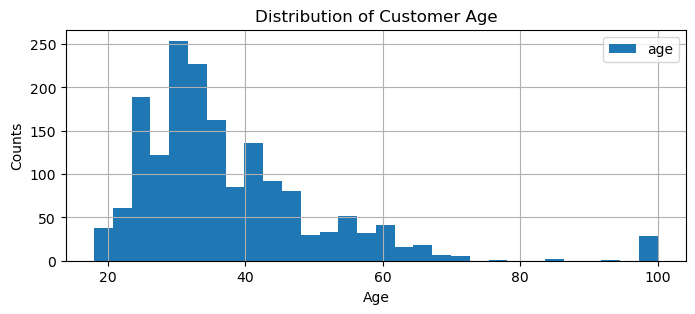

In [8]:
# let's visualize age on a graph with cliping at 100
df.age.clip(upper=100).hist(bins=30, legend=True, figsize=(8,3))
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

In [9]:
categorical_variables = ['destination','first_browser','language']

# Let's see how many unique values in each categorical variable
df[categorical_variables].nunique()

destination      11
first_browser    12
language         11
dtype: int64

Compared to the data, 11 to 12 unique values per each variable has moderate cardinality. One-hot encoding may not be the best procedure given that there would be 34 additional sparse columns added increasing overfitting. Though there are additional strategies such as data merging, or feature selection of one-hot encoded variable highly correlated with the booking variable, we will keep the MVP model simple by using ordinal encoding. This will represent each categorical value into a numeric value such that the classifer can be trained on the transformed data.

**Target variable**

In [10]:
# What's percentage of booking?
print(f"Booking Percentage: {df['booking'].mean():0.3}")

Booking Percentage: 0.333


There is 33% booking percentage shows that the target class is moderately imbalanced. This suggests AUC may be the best evaluation metric when evaluating the performance of classfier 

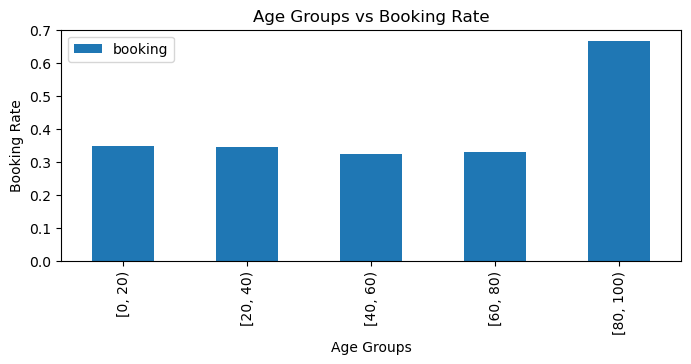

In [11]:
# Booking rate across age groups
bins = [0, 20, 40, 60, 80, 100]
df['age_intervals'] = pd.cut(df['age'], bins, right=False)
df.groupby('age_intervals')['booking'].mean().plot.bar(legend=True, figsize=(8,3))
plt.title('Age Groups vs Booking Rate')
plt.xlabel('Age Groups')
plt.ylabel('Booking Rate')
plt.show()

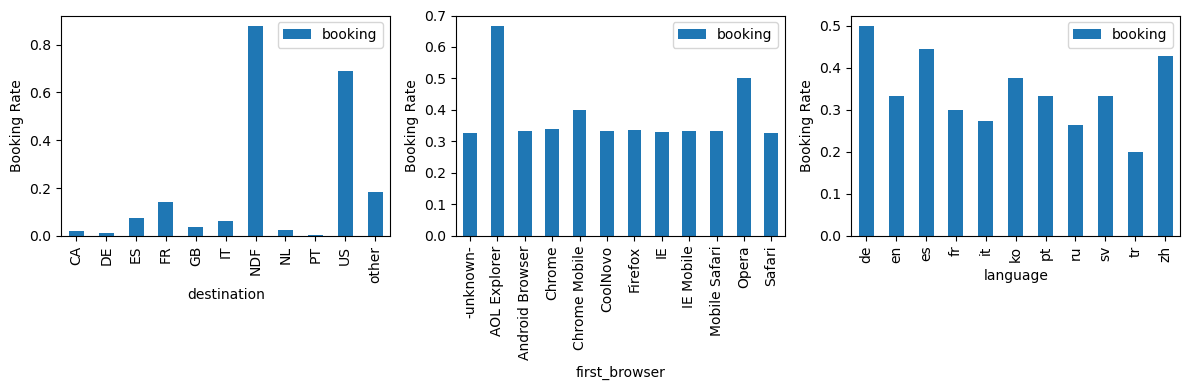

In [12]:
# Booking rate across age groups
f, axes = plt.subplots(figsize=(12,4), ncols=3)
for i, c in enumerate(categorical_variables):
    df.groupby(c)['booking'].mean().plot.bar(legend=True, ax=axes[i])
    axes[i].set_ylabel('Booking Rate')
plt.tight_layout()
plt.show()

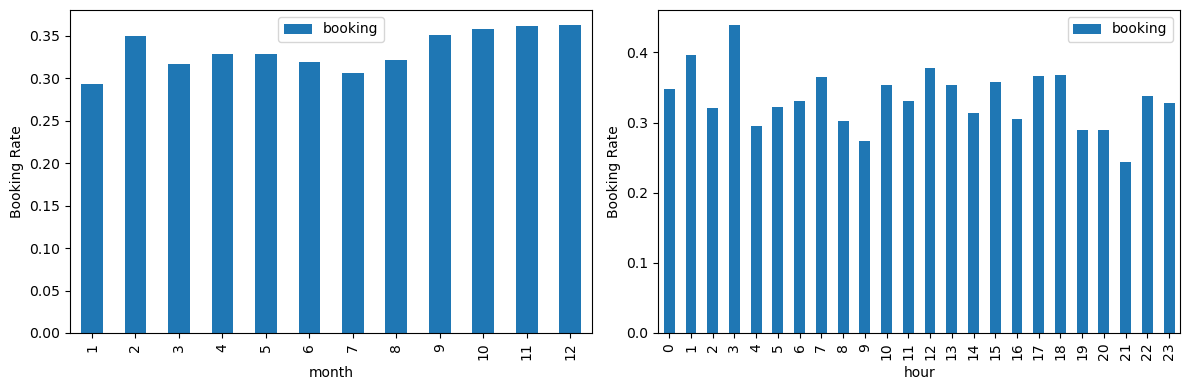

In [13]:
# Is there any seasonal patterns when booking is most likely or least likely?
df['session_date'] = pd.to_datetime(df['session_date'])
df['month'] = df['session_date'].dt.month
df['hour'] = df['session_date'].dt.hour

f, axes = plt.subplots(figsize=(12,4), ncols=2)
for i, c in enumerate(['month','hour']):
    df.groupby(c)['booking'].mean().plot.bar(legend=True, ax=axes[i])
    axes[i].set_ylabel('Booking Rate')
plt.tight_layout()
plt.show()

## Data Preparation

In [14]:
# Apply 80-20 split on the train and test
features = ['age','destination','first_browser','language','session_date']
target = ['booking']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=.2, random_state=SEED)

**Clip age at 100**

In [15]:
X_train['age'] = X_train['age'].clip(upper=100)
X_test['age'] = X_test['age'].clip(upper=100)

**Convert session date to datetime**

In [16]:
X_train['session_date'] = pd.to_datetime(X_train['session_date'])
X_test['session_date'] = pd.to_datetime(X_test['session_date'])

**Impute missing value**

In [17]:
# Imputing missing value in the age column
age_imputer = SimpleImputer(strategy='mean')
X_train['age'] = age_imputer.fit_transform(X_train[['age']])
X_test['age'] = age_imputer.fit_transform(X_test[['age']])

## Feature Engineering

**Ordinal Encoding**

In [18]:
# Map each categorical value to an integer value
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-99)
categorical_variables = ['destination', 'first_browser', 'language']
for c in categorical_variables: 
  X_train[c] = ordinal_encoder.fit_transform(X_train[[c]])
  X_test[c] = ordinal_encoder.transform(X_test[[c]])

**Age Binning**

Mutual information (MI) will be used to select meaningful features for the modeling step.To restrict the feature selection strategy to MI, all candidate signals must be categorical, or ordinal,and encoded into numerical values. All other variables can be treated as categorical, excluding "age". To mitigate this, discretize age first then encode it so that it can be fed into the MI feature selection strategy. 


In [19]:
bins = [0, 20, 40, 60, 80, 100]
X_train['age_intervals'] = pd.cut(X_train['age'], bins, right=True)
X_train['age_intervals'] = ordinal_encoder.fit_transform(X_train[['age_intervals']])

X_test['age_intervals'] = pd.cut(X_test['age'], bins, right=True)
X_test['age_intervals'] = ordinal_encoder.fit_transform(X_test[['age_intervals']])

**Time decomposition**

In [20]:
# Decompose session date into month and hour
X_train['month'] = X_train['session_date'].dt.month
X_train['hour'] = X_train['session_date'].dt.hour
X_test['month'] = X_test['session_date'].dt.month
X_test['hour'] = X_test['session_date'].dt.hour

In [27]:
X_test['hour']

1690     0
1798    22
417     13
1599    10
1206    10
        ..
813      6
174     22
2874    17
243     10
447     10
Name: hour, Length: 600, dtype: int32

## Feature Selection

In [21]:
# Apply mutual information on candidate signals
candidate_signals = ['age_intervals', 'destination', 'first_browser', 'language', 'month', 'hour']
scores = mutual_info_classif(X_train[candidate_signals], y_train.values.ravel(), random_state=SEED)

signal_mi = [(c, s) for c, s in zip(candidate_signals, scores)]
print('Mutual Information of candidate signals in the descending order:\n')
sorted(signal_mi, key=lambda x: x[1], reverse=True)

Mutual Information of candidate signals in the descending order:



[('destination', 0.3311324823655153),
 ('month', 0.0038035057982539477),
 ('hour', 0.002487287606713462),
 ('age_intervals', 0.0),
 ('first_browser', 0.0),
 ('language', 0.0)]

In [22]:
# Keep all signals that are non-zero as features for the model
features = [c for c, s in signal_mi if s > 0]; 
print(f'Model Features: {features}')

Model Features: ['destination', 'month', 'hour']


## Model Training

**Baseline model**

In [23]:
# Instantiate a model
rf_model = RandomForestClassifier(random_state=SEED)

# Fit a model
rf_model.fit(X_train[features], y_train.values.ravel())

RandomForestClassifier(random_state=123)

In [24]:
# Evaluate baseline performance
y_pred = rf_model.predict_proba(X_test[features])[:,1]
score = roc_auc_score(y_test, y_pred)
print(f'AUC: {score:.3f}')

AUC: 0.895


## Hyper-Parameter Tuning with GridSearchCV

In [25]:
# Parameters for GridSearch model tuning
param_grid = {
    'max_depth': range(3, 10, 1),
    'n_estimators': range(20, 80, 10)
}

# Use GridSearch to find the best parameters
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='roc_auc',
    n_jobs=-1, cv=5
)

grid_search.fit(X_train[features], y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10),
                         'n_estimators': range(20, 80, 10)},
             scoring='roc_auc')

In [26]:
# Evaluate grid search model performance
y_pred = grid_search.predict_proba(X_test[features])[:,1]
score = roc_auc_score(y_test, y_pred)
print(f'AUC: {score:.3f}')

AUC: 0.911
